# Music Generation Using Mubert

This notebook looks into music generation using the [Mubert](https://mubert.com/) API. 

The code here is mostly based on this [repo](https://github.com/MubertAI/Mubert-Text-to-Music) and those linked to from that repo.

In [ ]:
# The pip install instructions - in case you need them
%pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113
%pip install httpx sentence-transformers
%pip install ftfy regex tqdm transformers==4.21.2 timm fairscale
%pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip
%pip install -e git+https://github.com/pharmapsychotic/BLIP.git@main#egg=blipimport clip

# The above might not work for BLIP sometimes and it would give you an error about the import for "models.blip"
# If that happens, you'd need to clone the repo and then install the package from the cloned repo.
# Uncomment the code below to do that ...

#!git clone https://github.com/pharmapsychotic/BLIP.git
#%cd BLIP
#%pip install .

In [1]:
import clip
import gc
import hashlib
import os
import pickle
import torch
import httpx
import math
import numpy as np
import time
from IPython.display import Audio, display
from sentence_transformers import SentenceTransformer
from models.blip import blip_decoder
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm

Let's first look at basic Mubert usage. It's simple enough. You don't do any music generation locally. You call their API, generate the music on their server and get a URL to the newly generated track. But first, you need to get an access token to access their API.

The [Mubert API docs](https://mubert2.docs.apiary.io/#) have more details about the availabe API endpoints and the required parameters.

**Note:** If you use this notebook, make sure to fill in the `email` value before you run the notebook/cell.

In [ ]:
# Get Mubert access token
email = "<your e-mail here>"
r = httpx.post('https://api-b2b.mubert.com/v2/GetServiceAccess', 
    json={
        "method":"GetServiceAccess",
        "params": {
            "email": email,
            "license":"ttmmubertlicense#f0acYBenRcfeFpNT4wpYGaTQIyDI4mJGv5MfIhBFz97NXDwDNFHmMRsBSzmGsJwbTpP1A6i07AXcIeAHo5",
            "token":"4951f6428e83172a4f39de05d5b3ab10d58560b8",
            "mode": "loop"
        }
    }
)

rdata = json.loads(r.text)
assert rdata['status'] == 1, "probably incorrect e-mail"
token = rdata['data']['pat']
print(f'Mubert token: {token}')

In [37]:
transformer = SentenceTransformer('all-MiniLM-L6-v2')
# Mubert configuration info
mubert_tags_string = 'tribal,action,kids,neo-classic,run 130,pumped,jazz / funk,ethnic,dubtechno,reggae,acid jazz,liquidfunk,funk,witch house,tech house,underground,artists,mystical,disco,sensorium,r&b,agender,psychedelic trance / psytrance,peaceful,run 140,piano,run 160,setting,meditation,christmas,ambient,horror,cinematic,electro house,idm,bass,minimal,underscore,drums,glitchy,beautiful,technology,tribal house,country pop,jazz & funk,documentary,space,classical,valentines,chillstep,experimental,trap,new jack swing,drama,post-rock,tense,corporate,neutral,happy,analog,funky,spiritual,sberzvuk special,chill hop,dramatic,catchy,holidays,fitness 90,optimistic,orchestra,acid techno,energizing,romantic,minimal house,breaks,hyper pop,warm up,dreamy,dark,urban,microfunk,dub,nu disco,vogue,keys,hardcore,aggressive,indie,electro funk,beauty,relaxing,trance,pop,hiphop,soft,acoustic,chillrave / ethno-house,deep techno,angry,dance,fun,dubstep,tropical,latin pop,heroic,world music,inspirational,uplifting,atmosphere,art,epic,advertising,chillout,scary,spooky,slow ballad,saxophone,summer,erotic,jazzy,energy 100,kara mar,xmas,atmospheric,indie pop,hip-hop,yoga,reggaeton,lounge,travel,running,folk,chillrave & ethno-house,detective,darkambient,chill,fantasy,minimal techno,special,night,tropical house,downtempo,lullaby,meditative,upbeat,glitch hop,fitness,neurofunk,sexual,indie rock,future pop,jazz,cyberpunk,melancholic,happy hardcore,family / kids,synths,electric guitar,comedy,psychedelic trance & psytrance,edm,psychedelic rock,calm,zen,bells,podcast,melodic house,ethnic percussion,nature,heavy,bassline,indie dance,techno,drumnbass,synth pop,vaporwave,sad,8-bit,chillgressive,deep,orchestral,futuristic,hardtechno,nostalgic,big room,sci-fi,tutorial,joyful,pads,minimal 170,drill,ethnic 108,amusing,sleepy ambient,psychill,italo disco,lofi,house,acoustic guitar,bassline house,rock,k-pop,synthwave,deep house,electronica,gabber,nightlife,sport & fitness,road trip,celebration,electro,disco house,electronic'
mubert_tags = np.array(mubert_tags_string.split(','))
mubert_tags_embeddings = transformer.encode(mubert_tags)

In [38]:
def find_similar(em, embeddings, method='cosine'):
    scores = []
    for ref in embeddings:
        if method == 'cosine': 
            scores.append(1 - np.dot(ref, em) / (np.linalg.norm(ref) * np.linalg.norm(em)))
        if method == 'norm': 
            scores.append(np.linalg.norm(ref - em))
    return np.array(scores), np.argsort(scores)

def generate(prompt: str, duration: int, top: int = 3, loop: bool = False, max_check: int = 20,
    auto_play: bool = False):
    embeddings = transformer.encode([prompt])
    pe = embeddings[0]
    scores, idxs = find_similar(pe, mubert_tags_embeddings)
    first = idxs[:top]
    tags = list(mubert_tags[first])
    top_prob = 1 - scores[first]
    print(f"Prompt: {prompt}\nTags: {', '.join(tags)}\nScores: {top_prob}\n")
    # Get track
    if loop:
        mode = "loop"
    else:
        mode = "track"
    r = httpx.post('https://api-b2b.mubert.com/v2/RecordTrackTTM', 
        json={
            "method":"RecordTrackTTM",
            "params": {
                "pat": token, 
                "duration": duration,
                "tags": tags,
                "mode": mode
            }
        }
    )

    rdata = json.loads(r.text)
    assert rdata['status'] == 1, rdata['error']['text']
    trackurl = rdata['data']['tasks'][0]['download_link']
    print('Generating track ', end='')
    for i in range(max_check):
        r = httpx.get(trackurl)
        if r.status_code == 200:
            display(Audio(trackurl, autoplay=auto_play))
            break
        time.sleep(1)
        print('.', end='')

In [40]:
prompt = 'the dawning of spring'
duration = 30 

generate(prompt, duration, loop=False)

Prompt: the dawning of spring
Tags: summer, nature, night
Scores: [0.52162701 0.41321051 0.36950004]

Generating track ..

Basically, all that happens above is that the prompt is broken down and compared to the various Mubert tags (which are pre-set) and then the closest matches are used to generate a track with the given tags. Do note that the tag mechanism is not listed in the Mubert V2 API docs listed to at the top of this notebook. 

If you wanted to use the documented APIs, then you'd have to do something slightly different by getting a list of available channels, then mapping the channel names to the embeddings from the prompt similar to how the tags are matched, possibly.

## Image to Music

Given that the above method takes a prompt, it should be simple enough to take an input image, run it through a CLIP interrogator to get a some text about the image, and then use that text as the prompt to generate some music.

However, do note that this would be a very rough approximation given how the text/prompt to music above works. You are still matching for specific tags out of a very short list and not taking the context of the prompt fully into account when generating new music.

But it's a first step towards having the generated music being fully guided by the prompt, right? So let's give it a shot ...

**Note:** The CLIP interrogator code is based on [this repo](https://github.com/pharmapsychotic/clip-interrogator). You might need to run the following pip commands to install CLIP and BLIP:

```
pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip
pip install -e git+https://github.com/pharmapsychotic/BLIP.git@main#egg=blip
```

**Important:** This part of the notebook is memory intensive and takes a while to go through. The models are large and the BLIP data loading also takes up a fair amount of memory. Just be warned 🙂

### Apple Silicon / MPS

For Apple Silicon/MPS devices, installing BLIP might be a bit problematic due to getting tokenizers to install. The easiest option I could get working was to clone the `https://github.com/pharmapsychotic/BLIP.git` repo, remove version requirements from the requirements.txt file and then running a pip install from within the cloned repo like this:
```
pip install .
```

Do note that this will result in errors when you try to run the code because BLIP appears to rely on a specific (and older) version of `transformers`. You can fix the error quite easily by editing the `blip.py` file and changing the line around line 136 from:

```
model_kwargs = {"encoder_hidden_states": image_embeds, "encoder_attention_mask":image_atts}
```

to:
```
self.text_decoder.encoder_hidden_states = image_embeds
self.text_decoder.image_embeds = image_atts
model_kwargs = {}

```

If you try to run at this point, I believe this will throw up one more error and you have to modify `med.py` in BLIP at line 886 or so to change the `encoder_hidden_states` variable passed in the code at that point to use the encoders (which is the current class) own `encoder_hidden_states` property instead of the passed in `encoder_hidden_states` parameter. But you do need to know what you are doing here. So if you are on MPS and are not too happy with messing with code, you might be better off running this in a Colab 🙂 Hopefully, on Colab you should be able to install the required version of transformers and be all set!

In [3]:
dev_str = 'cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu'
device = torch.device(dev_str)

print("Loading BLIP model...")
blip_image_eval_size = 384
blip_model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth'        
blip_model = blip_decoder(pretrained=blip_model_url, image_size=blip_image_eval_size, vit='large', med_config='configs/med_config.json')
blip_model = blip_model.to(device)
blip_model.eval()

print("Loading CLIP model...")
# Options - 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px', 'RN101', 'RN50', 'RN50x4', 'RN50x16', 'RN50x64'
clip_model_name = 'ViT-L/14' 
clip_model, clip_preprocess = clip.load(clip_model_name, device=device)
clip_model = clip_model.to(device)
_ = clip_model.eval()

Loading BLIP model...
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...


In [4]:
# CLIP utility methods
def generate_caption(pil_image):
    # Prepare image
    gpu_image = transforms.Compose([
        transforms.Resize((blip_image_eval_size, blip_image_eval_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])(pil_image).unsqueeze(0).to(device)
    # Get caption
    with torch.no_grad():
        caption = blip_model.generate(gpu_image, sample=False, num_beams=3, max_length=20, min_length=5)
    return caption[0]

def similarity(image_features, text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokens).float()       
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity[0][0]

def interrogate(image):
    caption = generate_caption(image)

    images = clip_preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

    flaves = flavors.rank(image_features, flavor_intermediate_count)
    best_medium = mediums.rank(image_features, 1)[0]
    best_artist = artists.rank(image_features, 1)[0]
    best_trending = trendings.rank(image_features, 1)[0]
    best_movement = movements.rank(image_features, 1)[0]

    best_prompt = caption
    best_sim = similarity(image_features, best_prompt)

    def check(addition):
        nonlocal best_prompt, best_sim
        prompt = best_prompt + ", " + addition
        sim = similarity(image_features, prompt)
        if sim > best_sim:
            best_sim = sim
            best_prompt = prompt
            return True
        return False

    def check_multi_batch(opts):
        nonlocal best_prompt, best_sim
        prompts = []
        for i in range(2**len(opts)):
            prompt = best_prompt
            for bit in range(len(opts)):
                if i & (1 << bit):
                    prompt += ", " + opts[bit]
            prompts.append(prompt)

        t = LabelTable(prompts, None)
        best_prompt = t.rank(image_features, 1)[0]
        best_sim = similarity(image_features, best_prompt)

    check_multi_batch([best_medium, best_artist, best_trending, best_movement])

    extended_flavors = set(flaves)
    for _ in tqdm(range(25), desc="Flavor chain"):
        try:
            best = rank_top(image_features, [f"{best_prompt}, {f}" for f in extended_flavors])
            flave = best[len(best_prompt)+2:]
            if not check(flave):
                break
            extended_flavors.remove(flave)
        except:
            # exceeded max prompt length
            break

    return best_prompt

In [7]:
# BLIP data
sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
trending_list = [site for site in sites]
trending_list.extend(["trending on "+site for site in sites])
trending_list.extend(["featured on "+site for site in sites])
trending_list.extend([site+" contest winner" for site in sites])

In [17]:
# Data loading
def load_list(filename):
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

raw_artists = load_list(f'data/artists.txt')
artists = [f"by {a}" for a in raw_artists]
artists.extend([f"inspired by {a}" for a in raw_artists])

class LabelTable():
    def __init__(self, labels, desc):
        self.labels = labels
        self.embeds = []

        hash = hashlib.sha256(",".join(labels).encode()).hexdigest()

        os.makedirs('./cache', exist_ok=True)
        cache_filepath = f"./cache/{desc}.pkl"
        if desc is not None and os.path.exists(cache_filepath):
            with open(cache_filepath, 'rb') as f:
                data = pickle.load(f)
                if data.get('hash') == hash and data.get('model') == clip_model_name:
                    self.labels = data['labels']
                    self.embeds = data['embeds']

        if len(self.labels) != len(self.embeds):
            self.embeds = []
            chunks = np.array_split(self.labels, max(1, len(self.labels)/chunk_size))
            for chunk in tqdm(chunks, desc=f"Preprocessing {desc}" if desc else None):
                text_tokens = clip.tokenize(chunk).to(device)
                with torch.no_grad():
                    text_features = clip_model.encode_text(text_tokens).float()
                text_features /= text_features.norm(dim=-1, keepdim=True)
                text_features = text_features.half().cpu().numpy()
                for i in range(text_features.shape[0]):
                    self.embeds.append(text_features[i])

            with open(cache_filepath, 'wb') as f:
                pickle.dump({"labels":self.labels, "embeds":self.embeds, "hash":hash, "model":clip_model_name}, f)
    
    def _rank(self, image_features, text_embeds, top_count=1):
        top_count = min(top_count, len(text_embeds))
        similarity = torch.zeros((1, len(text_embeds))).to(device)
        text_embeds = torch.stack([torch.from_numpy(t) for t in text_embeds]).float().to(device)
        for i in range(image_features.shape[0]):
            similarity += (image_features[i].unsqueeze(0) @ text_embeds.T).softmax(dim=-1)
        _, top_labels = similarity.cpu().topk(top_count, dim=-1)
        return [top_labels[0][i].numpy() for i in range(top_count)]

    def rank(self, image_features, top_count=1):
        if len(self.labels) <= chunk_size:
            tops = self._rank(image_features, self.embeds, top_count=top_count)
            return [self.labels[i] for i in tops]

        num_chunks = int(math.ceil(len(self.labels)/chunk_size))
        keep_per_chunk = int(chunk_size / num_chunks)

        top_labels, top_embeds = [], []
        for chunk_idx in tqdm(range(num_chunks)):
            start = chunk_idx*chunk_size
            stop = min(start+chunk_size, len(self.embeds))
            tops = self._rank(image_features, self.embeds[start:stop], top_count=keep_per_chunk)
            top_labels.extend([self.labels[start+i] for i in tops])
            top_embeds.extend([self.embeds[start+i] for i in tops])

        tops = self._rank(image_features, top_embeds, top_count=top_count)
        return [top_labels[i] for i in tops]

In [24]:
chunk_size = 2048
flavor_intermediate_count = 2048
gc.collect()
artists = LabelTable(artists, "artists")
gc.collect()
mediums = LabelTable(load_list(f'data/mediums.txt'), "mediums")
movements = LabelTable(load_list(f'data/movements.txt'), "movements")
trendings = LabelTable(trending_list, "trendings")
gc.collect()
flavors = LabelTable(load_list(f'data/flavors.txt'), "flavors")

Preprocessing artists: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:01<00:00, 96.25s/it]


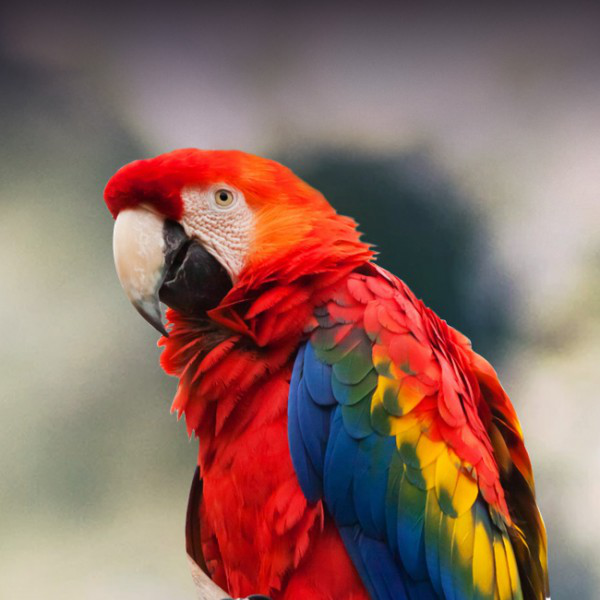

In [5]:
# Load the image we'll be using
image = Image.open('images/macaw.jpg')
image

In [36]:
# Interrogate image
flavor_intermediate_count = 2048
prompt = interrogate(image)
prompt

Flavor chain:   0%|                                                                                                                                               | 0/25 [00:00<?, ?it/s]


'a underside a a a a a a a a a a a a a a, a jigsaw puzzle, inspired by Robert Macaulay Stevenson, shutterstock contest winner'

Hmm ... not very accurte is it? But I guess that's what you get ... There might be ways to improve the results, but that's something we'll leave for later. But now that we do have a prompt, the rest is easy as far as generating music goes. All we have to do is pass the prompt we got to our music generator function ...

In [39]:
generate(prompt, 30, loop=False)

Prompt: a underside a a a a a a a a a a a a a a, a jigsaw puzzle, inspired by Robert Macaulay Stevenson, shutterstock contest winner
Tags: drill, pads, sberzvuk special
Scores: [0.28437701 0.23324785 0.23232725]

Generating track ..

And that's it! Whether it feels like it or not (it really doesn't to me ..) we did generate some music based on an image. But if you try with different images, you'll notice that the music doesn't really capture the mood of the image most of the time ... That's something that can be worked on as an improvement perhaps?

If you figure out better ways to do things, do let me know! I'd be interested to hear all about it 🙂